In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
%%time
main_directory = "./data"

subdirectories = [f.path for f in os.scandir(main_directory) if f.is_dir()]
dfs = []

for directory in subdirectories:
    files = [f for f in os.scandir(directory) if f.name.endswith('.csv')]
    
    for file in files:
        file_path = file.path
        df_temp = pd.read_csv(file_path)
        x = df_temp['accelerometer_X']
        y = df_temp['accelerometer_Y']
        z = df_temp['accelerometer_Z']
        df_temp['mean_x'] = x.mean()
        df_temp['mean_y'] = y.mean()
        df_temp['mean_z'] = z.mean()
        df_temp['var_x'] = x.var()
        df_temp['var_y'] = y.var()
        df_temp['var_z'] = z.var()
        df_temp['std_x'] = x.std(ddof=0)
        df_temp['std_y'] = y.std(ddof=0)
        df_temp['std_z'] = z.std(ddof=0)
        df_temp['median_x'] = x.median()
        df_temp['median_y'] = y.median()
        df_temp['median_z'] = z.median()
        df_temp['max_x'] = x.max()
        df_temp['max_y'] = y.max()
        df_temp['max_z'] = z.max()
        df_temp['min_x'] = x.min()
        df_temp['min_y'] = y.min()
        df_temp['min_z'] = z.min()
        df_temp['rms_x'] = np.sqrt((x ** 2).mean())
        df_temp['rms_y'] = np.sqrt((y ** 2).mean())
        df_temp['rms_z'] = np.sqrt((z ** 2).mean())
        df_temp['power_x'] = (x ** 2).sum()
        df_temp['power_y'] = (y ** 2).sum()
        df_temp['power_z'] = (z ** 2).sum()
        df_temp['skewness_x'] = x.skew()
        df_temp['skewness_y'] = y.skew()
        df_temp['skewness_z'] = z.skew()
        df_temp['kurtosis_x'] = x.kurtosis()
        df_temp['kurtosis_y'] = y.kurtosis()
        df_temp['kurtosis_z'] = z.kurtosis()
        df_temp['iqr_x'] = x.quantile(0.75) - x.quantile(0.25)
        df_temp['iqr_y'] = y.quantile(0.75) - y.quantile(0.25)
        df_temp['iqr_z'] = z.quantile(0.75) - z.quantile(0.25)
        df_temp['mad_x'] = np.mean(np.abs(x - np.mean(x)))
        df_temp['mad_y'] = np.mean(np.abs(y - np.mean(y)))
        df_temp['mad_z'] = np.mean(np.abs(z - np.mean(z)))
        df_temp['range_x'] = x.max() - x.min()
        df_temp['range_y'] = y.max() - y.min()
        df_temp['range_z'] = z.max() - z.min()
        df_temp['min_index_x'] = x.idxmin()
        df_temp['min_index_y'] = y.idxmin()
        df_temp['min_index_z'] = z.idxmin()
        df_temp['max_index_x'] = x.idxmax()
        df_temp['max_index_y'] = y.idxmax()
        df_temp['max_index_z'] = z.idxmax()
        df_temp['energy_x'] = (1 / len(x)) * (x ** 2).sum()
        df_temp['energy_y'] = (1 / len(y)) * (y ** 2).sum()
        df_temp['energy_z'] = (1 / len(z)) * (z ** 2).sum()

        
        df_temp['folder'] = os.path.basename(directory)
        df_temp['file'] = os.path.splitext(file.name)[0]
        df_temp['index_file'] = range(len(df_temp))
        
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

df.head()

CPU times: total: 1min 49s
Wall time: 2min 6s


,accelerometer_X,accelerometer_Y,accelerometer_Z,mean_x,mean_y,mean_z,var_x,var_y,var_z,std_x,...,min_index_z,max_index_x,max_index_y,max_index_z,energy_x,energy_y,energy_z,folder,file,index_file
0,1.000776,4.616021,8.576031,0.178448,0.167435,9.605697,1.074044,1.340046,0.16557,1.018942,...,3,3,0,23,1.070086,1.323412,92.429464,idle,idle-1,0
1,0.718261,4.209007,8.446744,0.178448,0.167435,9.605697,1.074044,1.340046,0.16557,1.018942,...,3,3,0,23,1.070086,1.323412,92.429464,idle,idle-1,1
2,-0.909797,-0.282516,9.203311,0.178448,0.167435,9.605697,1.074044,1.340046,0.16557,1.018942,...,3,3,0,23,1.070086,1.323412,92.429464,idle,idle-1,2
3,5.099650,0.148441,8.418014,0.178448,0.167435,9.605697,1.074044,1.340046,0.16557,1.018942,...,3,3,0,23,1.070086,1.323412,92.429464,idle,idle-1,3
4,1.762132,-0.162806,9.251195,0.178448,0.167435,9.605697,1.074044,1.340046,0.16557,1.018942,...,3,3,0,23,1.070086,1.323412,92.429464,idle,idle-1,4


In [3]:
files = df.file.unique()
sample = np.random.choice(files, size=int(len(files)*0.4), replace=False)
train = df[df['file'].isin(sample)].reset_index(drop=True)

In [4]:
test_files = np.setdiff1d(files, sample)
test = df[df['file'].isin(test_files)].reset_index(drop=True)

In [5]:
x_train = train.drop(columns=['file', 'folder'])
y_train = train['folder']
x_test = test.drop(columns=['file', 'folder'])
y_test = test['folder']

In [6]:
scaler = StandardScaler()
data_to_normalize = x_train[x_train.drop(columns=['max_index_x','max_index_y','max_index_z',
       'min_index_x', 'min_index_y', 'min_index_z','index_file']).columns]

normalized_data = scaler.fit_transform(data_to_normalize)

x_n_train = x_train.copy()
x_n_train[x_train.drop(columns=['max_index_x','max_index_y','max_index_z',
       'min_index_x', 'min_index_y', 'min_index_z','index_file']).columns] = normalized_data
x_n_train

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean_x,mean_y,mean_z,var_x,var_y,var_z,std_x,...,min_index_x,min_index_y,min_index_z,max_index_x,max_index_y,max_index_z,energy_x,energy_y,energy_z,index_file
0,-0.163727,-0.108388,1.096467,-0.307377,-0.174067,2.161126,-1.080608,-1.145621,-1.422126,-1.631554,...,27,26,18,26,27,26,-1.074440,-1.725939,1.458170,0
1,-0.166029,-0.115346,1.098456,-0.307377,-0.174067,2.161126,-1.080608,-1.145621,-1.422126,-1.631554,...,27,26,18,26,27,26,-1.074440,-1.725939,1.458170,1
2,-0.165453,-0.112640,1.096467,-0.307377,-0.174067,2.161126,-1.080608,-1.145621,-1.422126,-1.631554,...,27,26,18,26,27,26,-1.074440,-1.725939,1.458170,2
3,-0.162576,-0.119598,1.101772,-0.307377,-0.174067,2.161126,-1.080608,-1.145621,-1.422126,-1.631554,...,27,26,18,26,27,26,-1.074440,-1.725939,1.458170,3
4,-0.176964,-0.106455,1.097130,-0.307377,-0.174067,2.161126,-1.080608,-1.145621,-1.422126,-1.631554,...,27,26,18,26,27,26,-1.074440,-1.725939,1.458170,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77515,0.332971,-0.096405,4.263052,-0.308322,-1.498217,-0.550063,-0.820279,-0.795905,1.249312,-0.700623,...,1,18,2,18,25,25,-0.901157,-0.153338,0.632127,25
77516,0.457289,-1.160986,-0.304126,-0.308322,-1.498217,-0.550063,-0.820279,-0.795905,1.249312,-0.700623,...,1,18,2,18,25,25,-0.901157,-0.153338,0.632127,26
77517,0.224768,-0.988968,-1.229233,-0.308322,-1.498217,-0.550063,-0.820279,-0.795905,1.249312,-0.700623,...,1,18,2,18,25,25,-0.901157,-0.153338,0.632127,27
77518,0.016420,-0.845555,-0.637032,-0.308322,-1.498217,-0.550063,-0.820279,-0.795905,1.249312,-0.700623,...,1,18,2,18,25,25,-0.901157,-0.153338,0.632127,28


In [7]:
data_to_normalize = x_test[x_test.drop(columns=['max_index_x','max_index_y','max_index_z',
       'min_index_x', 'min_index_y', 'min_index_z','index_file']).columns]

normalized_data = scaler.fit_transform(data_to_normalize)

x_n_test = x_test.copy()
x_n_test[x_test.drop(columns=['max_index_x','max_index_y','max_index_z',
       'min_index_x', 'min_index_y', 'min_index_z','index_file']).columns] = normalized_data
x_n_test

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean_x,mean_y,mean_z,var_x,var_y,var_z,std_x,...,min_index_x,min_index_y,min_index_z,max_index_x,max_index_y,max_index_z,energy_x,energy_y,energy_z,index_file
0,-0.118592,0.229034,0.945274,-0.395854,-0.197001,2.161971,-1.106594,-1.182128,-1.470149,-1.417236,...,2,2,3,3,0,23,-1.113735,-1.749941,1.428799,0
1,-0.151986,0.196548,0.927248,-0.395854,-0.197001,2.161971,-1.106594,-1.182128,-1.470149,-1.417236,...,2,2,3,3,0,23,-1.113735,-1.749941,1.428799,1
2,-0.344425,-0.161934,1.032735,-0.395854,-0.197001,2.161971,-1.106594,-1.182128,-1.470149,-1.417236,...,2,2,3,3,0,23,-1.113735,-1.749941,1.428799,2
3,0.365902,-0.127538,0.923242,-0.395854,-0.197001,2.161971,-1.106594,-1.182128,-1.470149,-1.417236,...,2,2,3,3,0,23,-1.113735,-1.749941,1.428799,3
4,-0.028598,-0.152379,1.039411,-0.395854,-0.197001,2.161971,-1.106594,-1.182128,-1.470149,-1.417236,...,2,2,3,3,0,23,-1.113735,-1.749941,1.428799,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116335,0.367034,-1.372670,-0.455430,-0.189099,-1.582481,-0.425291,-0.744630,-0.828652,0.867993,-0.548622,...,23,10,10,24,17,17,-0.854216,-0.129788,0.240867,25
116336,0.516457,-1.076483,-1.397467,-0.189099,-1.582481,-0.425291,-0.744630,-0.828652,0.867993,-0.548622,...,23,10,10,24,17,17,-0.854216,-0.129788,0.240867,26
116337,0.151955,-0.936988,-0.303876,-0.189099,-1.582481,-0.425291,-0.744630,-0.828652,0.867993,-0.548622,...,23,10,10,24,17,17,-0.854216,-0.129788,0.240867,27
116338,-0.588935,-0.382832,-0.072874,-0.189099,-1.582481,-0.425291,-0.744630,-0.828652,0.867993,-0.548622,...,23,10,10,24,17,17,-0.854216,-0.129788,0.240867,28


In [8]:
%%time

model_svm = SVC()
model_svm.fit(x_n_train, y_train)

CPU times: total: 17.7 s
Wall time: 20.6 s


SVC()

In [9]:
%%time

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(x_train, y_train)

CPU times: total: 9.16 s
Wall time: 10.5 s


RandomForestClassifier()

In [10]:
y_predicted_svm = model_svm.predict(x_n_test)
y_predicted_rf = model_rf.predict(x_test)

svm_accuracy = accuracy_score(y_test, y_predicted_svm)
rf_accuracy = accuracy_score(y_test, y_predicted_rf)

Точність моделі SVM:0.9902698985731476
Точність моделі випадкового лісу:0.9987192711019426


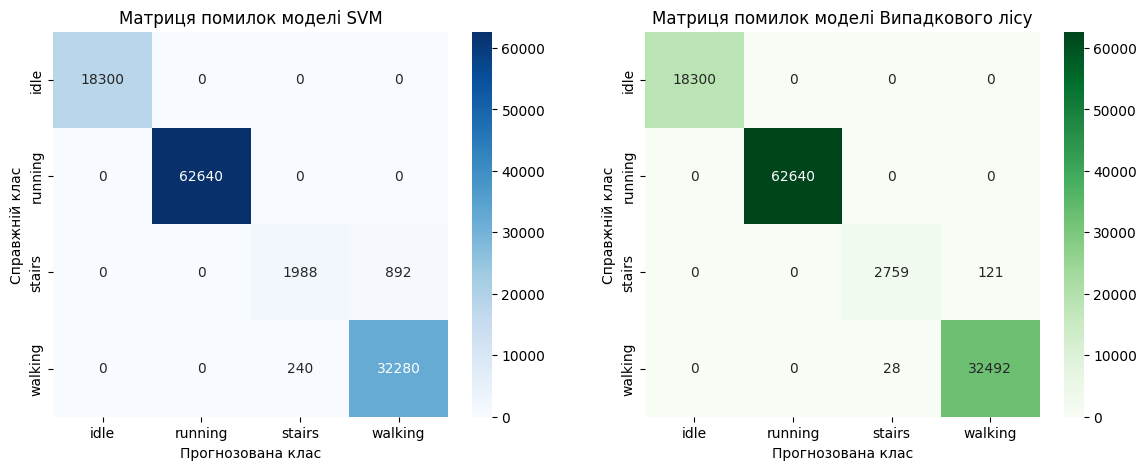

In [11]:
svm_confusion_matrix = confusion_matrix(y_test, y_predicted_svm)
rf_confusion_matrix = confusion_matrix(y_test, y_predicted_rf)

print(f'Точність моделі SVM:{svm_accuracy}')
print(f'Точність моделі випадкового лісу:{rf_accuracy}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(svm_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=df.folder.unique(), yticklabels=df.folder.unique(), ax=axes[0])
axes[0].set_title('Матриця помилок моделі SVM')
axes[0].set_xlabel('Прогнозована клас')
axes[0].set_ylabel('Справжній клас')

sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=df.folder.unique(), yticklabels=df.folder.unique(), ax=axes[1])
axes[1].set_title('Матриця помилок моделі Випадкового лісу')
axes[1].set_xlabel('Прогнозована клас')
axes[1].set_ylabel('Справжній клас')

plt.show()